[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)


# 节点并行执行

## 回顾

在模块 3 中，我们深入探讨了 `human-in-the loop`，展示了 3 个常见用例：

(1) `Approval`（批准）- 我们可以中断智能体，向用户展示状态，并允许用户接受某个动作

(2) `Debugging`（调试）- 我们可以回滚图，以复现或规避问题

(3) `Editing`（编辑）- 你可以修改状态

## 目标

本模块会在 `human-in-the-loop` 以及模块 2 中讨论的 `memory` 概念基础上继续扩展。

我们将深入 `multi-agent` 工作流，并逐步构建一个多智能体研究助理，把本课程的所有模块串联起来。

为了构建这个多智能体研究助理，我们先聊聊几个 LangGraph 的可控性主题。

我们从[并行化](https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-create-branches-for-parallel-node-execution)开始。

## 发散与汇合

先来搭建一个简单的线性图，每一步都会覆盖状态。


In [1]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

In [2]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

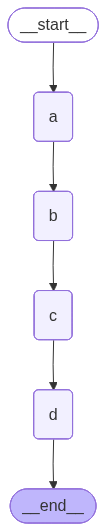

In [3]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    # NOTE: 这里是覆盖不是追加
    state: str


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        # print(f"Adding {self._value} to {state['state']}")
        print(f"Replacing {self._value} to {state['state']}")
        return {"state": [self._value]}


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

正如预期，我们覆盖了状态。


In [4]:
graph.invoke({"state": []})

Replacing I'm A to []
Replacing I'm B to ["I'm A"]
Replacing I'm C to ["I'm B"]
Replacing I'm D to ["I'm C"]


{'state': ["I'm D"]}

现在让我们让 `b` 和 `c` 并行运行。

然后运行 `d`。

我们只需让 `a` 扇出（fan-out）到 `b` 和 `c`，然后再汇合（fan-in）到 `d` 即可。

状态更新会在每一步结束时应用。

执行看看。


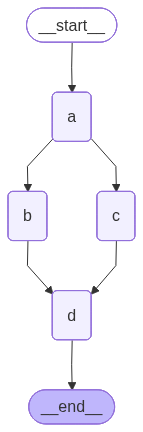

In [5]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**我们看到了错误！**

这是因为 `b` 和 `c` 在同一步中都写入了同一个状态键 / 通道。


In [6]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Replacing I'm A to []
Replacing I'm B to ["I'm A"]
Replacing I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


在使用扇出时，如果多个步骤写到同一个通道 / 键，就必须使用某种归约器。

正如我们在模块 2 中提到的，`operator.add` 来自 Python 内置的 operator 模块。

当它用于列表时，会执行列表拼接。


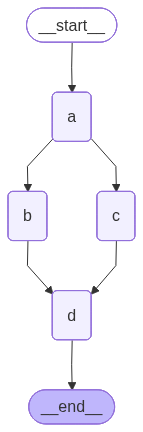

In [7]:
import operator
from typing import Annotated


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        # print(f"Replacing {self._value} to {state['state']}")
        return {"state": [self._value]}


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

现在我们可以看到，`b` 和 `c` 并行执行时的更新被追加到了状态中。


## 等待节点完成

再来看一种情况：一条并行路径比另一条拥有更多步骤。


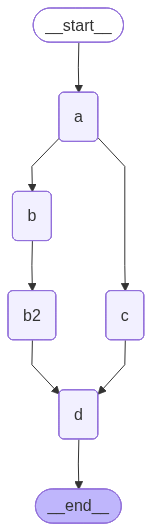

In [9]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

在这种情况下，`b`、`b2` 和 `c` 都属于同一步。

图会等到它们全部完成之后才进入下一步 `d`。


In [10]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## 设置状态更新的顺序

然而，在同一步内部，我们无法精确控制状态更新的顺序！

简单来说，这个顺序是 LangGraph 根据图的拓扑结构给出的确定性顺序，但**我们无法直接控制**。

上面的例子中，`c` 在 `b2` 之前被追加。

不过，我们可以定义自定义归约器来调整顺序，例如对状态更新进行排序。


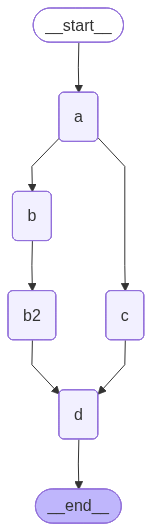

In [13]:
def sorting_reducer(left, right):
    """Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]

    return sorted(left + right, reverse=False)


class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        # print(f"Replacing {self._value} to {state['state']}")
        return {"state": [self._value]}


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

In [ ]:
sorted(["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"], reverse=False)

["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]

现在，这个归约器会对更新后的状态值进行排序！

`sorting_reducer` 示例会对所有值做全局排序。我们还可以：

1. 在并行步骤中把输出写到状态的某个临时字段
2. 在并行步骤之后加一个 “汇总” 节点来整合并排序这些输出
3. 合并完后清理临时字段

更多细节参见[文档](https://langchain-ai.github.io/langgraph/how-tos/branching/#stable-sorting)。


## 与 LLM 协作

现在，加一个更贴近实际的例子！

我们希望从两个外部来源（维基百科和网页搜索）收集上下文，再让 LLM 回答问题。


In [ ]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o", temperature=0)
from langchain_community.chat_models import ChatTongyi

llm = ChatTongyi(model="qwen-plus", temperature=0)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [17]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

你可以尝试不同的网页搜索工具。[Tavily](https://tavily.com/) 是一个不错的选项，不过记得先设置 `TAVILY_API_KEY`。


In [18]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

In [21]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults


def search_web(state):
    """Retrieve docs from web search"""

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state["question"])

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_wikipedia(state):
    """Retrieve docs from wikipedia"""

    # Search
    search_docs = WikipediaLoader(query=state["question"], load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_answer(state):
    """Node to answer a question"""

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)

    # Answer
    answer = llm.invoke(
        [SystemMessage(content=answer_instructions)]
        + [HumanMessage(content=f"Answer the question.")]
    )

    # Append it to state
    return {"answer": answer}


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

# display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result["answer"].content

/var/folders/zr/zsgg61wn27zbcvccfss34hpw0000gq/T/ipykernel_27042/2604567089.py:11: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


"Nvidia's Q2 2024 earnings were exceptionally strong, far exceeding expectations and reflecting the company's dominant position in the AI-driven semiconductor market.\n\nFor the quarter ending July 30, 2024 (referred to as Q2 of fiscal 2025), Nvidia reported:\n\n- **Revenue**: $30.0 billion, a 122% increase year-over-year and significantly higher than Wall Street estimates. This marked a record for the company.\n- **Data Center Revenue**: $26.3 billion, up 154% from the previous year, driven by surging demand for AI chips from cloud service providers and tech giants like Alphabet, Amazon, and Meta.\n- **Earnings Per Share (EPS)**: Diluted EPS was 67 cents, beating analyst expectations, though this figure appears to be GAAP-based; adjusted EPS in prior quarters had been much higher (e.g., $2.70 in an earlier report, possibly due to different reporting periods or adjustments).\n- **Gross Margin**: Adjusted gross margin reached 71.2%, up 25.3 percentage points year-over-year, due to high 

## 搭配 LangGraph API 使用

**⚠️ 免责声明**

自从录制这些视频以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。现在推荐的方式是以这种形式运行 Studio（而不是像视频中展示的桌面应用）。关于本地开发服务器请查看[这里](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)的文档，关于本地 Studio 的运行方式请查看[这里](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。在本模块的 `/studio` 目录中，在终端运行以下命令即可启动本地开发服务器：

```
langgraph dev
```

你应该会看到如下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

在浏览器中访问 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。


In [ ]:
if "google.colab" in str(get_ipython()):
    raise Exception(
        "Unfortunately LangGraph Studio is currently not supported on Google Colab"
    )

In [23]:
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")

In [24]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2024 earnings?"}
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="parallelization",
    input=input_question,
    stream_mode="values",
):
    # Check if answer has been added to state
    if event.data is not None:
        answer = event.data.get("answer", None)
        if answer:
            print(answer["content"])

Nvidia's Q2 2024 earnings (for the quarter ended July 28, 2024) were exceptionally strong, reflecting continued growth driven by demand for AI and data center technologies.

Key highlights include:

- **Revenue**: $30.0 billion, up 15% from the previous quarter and a significant 122% increase compared to the same quarter last year.
- **Data Center Revenue**: Reached a record $26.3 billion, up 16% sequentially and 154% year-over-year, underscoring Nvidia's dominance in AI infrastructure.
- **Net Income**: Reported at $16.6 billion, a 168% increase from the prior year.
- **Earnings Per Share (EPS)**: Adjusted diluted EPS was $0.68, beating analyst expectations and up 152% year-over-year.
- **Outperformance**: Revenue exceeded analyst consensus of $28.7 billion by $1.3 billion, and data center revenue surpassed expectations by $1.1 billion.
- **Guidance**: For Q3 2024, Nvidia projected revenue of $32.5 billion, above analyst estimates, signaling sustained momentum.
- **Shareholder Returns

In [27]:
thread = await client.threads.create()
input_question = {"question": "伍佰2025年开演唱会了吗"}
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="parallelization",
    input=input_question,
    stream_mode="values",
):
    # Check if answer has been added to state
    if event.data is not None:
        answer = event.data.get("answer", None)
        if answer:
            print(answer["content"])

是的，伍佰將在2025年舉辦演唱會。他將於**2025年6月13日至15日**在**台北小巨蛋**舉行「國泰世華銀行 伍佰 Wu Bai & China Blue Rock Star 2 世界巡迴演唱會台北站」，一連三天共演出三場。票務資訊顯示，正式售票時間為2025年3月15日中午12:00，採全場實名制，透過tixCraft拓元售票系統購票。
